# <center>PRÁCTICA 2: APRENDIZAJE SUPERVISADO (DengAI)<center>

##Autor : Yovanny Enriue Alvarado Perez


##Usuario VIU : yalvaradop@student.universidadviu.com

### Resumen

En esta práctica se ha desarrollado un modelo de aprendizaje supervisado para predecir la cantidad de casos semanales de dengue en las ciudades de San Juan e Iquitos, a partir de variables meteorológicas. El proceso ha seguido un enfoque estructurado que incluye: carga y limpieza de datos, interpolación de valores nulos, selección de características, normalización, entrenamiento de modelos, validación cruzada y evaluación final mediante la plataforma DrivenData.

Se han probado diversos algoritmos de regresión como **Random Forest**, **XGBoost** y **Gradient Boosting**, evaluando su rendimiento con la métrica MAE tanto en validación como en test. Finalmente, se eligió el modelo que mejor equilibraba precisión y generalización.

Los mejores resultados se obtuvieron con **Gradient Boosting**, con un MAE de **25.7428 en DrivenData**, lo cual indica un desempeño competitivo. Se aplicaron técnicas de preprocesamiento sólidas y se diseñó un flujo reproducible de experimentación, cumpliendo los requisitos de la plantilla oficial.

[[IMPORTANTE: Será necesario registrarse en la competición de DengAI de DrivenData para poder descargar el dataset:  
https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/ ]]


##Inicio

##Paso 1: Cargar y unir datos

In [73]:
# Librerías generales
import pandas as pd
import numpy as np
import time
import io
from google.colab import files

# Librerías de machine learning
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error
!pip install xgboost

# Fijar semilla
seed = 42
np.random.seed(seed)

# Función para exportar predicciones en formato DrivenData
def download_predictions(test, pred_total_cases):
    file_name = "practica2_pred_" + time.strftime("%y%m%d_%H%M%S") + ".csv"
    predictions = pd.DataFrame({
        "city": test["city"],
        "year": test["year"],
        "weekofyear": test["weekofyear"],
        "total_cases": pred_total_cases
    })
    predictions.to_csv(file_name, index=False)
    files.download(file_name)
    print("Archivo descargado:", file_name)


##2 – Subida y unión de datos

In [75]:
# 2. CARGA DE ARCHIVOS

# Subir datasets
train_feat = pd.read_csv("dengue_features_train (1).csv")
train_labels = pd.read_csv("dengue_labels_train (1).csv")
test = pd.read_csv("dengue_features_test (3).csv")

# Unir datos de entrenamiento con las etiquetas
train = pd.merge(train_feat, train_labels, on=["city", "year", "weekofyear"])

# Verificar dimensiones
print("Train:", train.shape)
print("Test:", test.shape)


Train: (1456, 25)
Test: (416, 24)


## 3 – Reexploración y Preprocesamiento

Durante esta fase se realizó una expansión del análisis exploratorio efectuado previamente, esta vez considerando también la variable objetivo total_cases. Este enfoque permitió identificar relaciones significativas entre algunas variables meteorológicas y el número de casos de dengue registrados semanalmente.

En primer lugar, se eliminaron variables irrelevantes como week_start_date, por ser de tipo texto y no aportar valor predictivo directo. Luego se procedió a la detección y tratamiento de valores nulos mediante el método interpolate, lo cual permitió conservar más información y evitar sesgos provocados por la imputación constante (como fillna(method='ffill')).

Posteriormente, se llevó a cabo un proceso de codificación de la variable categórica city, binarizándola para facilitar su uso en modelos supervisados. Asimismo, se seleccionó un conjunto representativo de características numéricas que demostraron tener correlación con la variable objetivo, como la humedad específica, la temperatura promedio y la temperatura mínima, entre otras.

Se detectaron posibles valores atípicos mediante boxplots, lo cual permitió refinar aún más el dataset. También se aplicó escalado de variables mediante MinMaxScaler, con el fin de mejorar el rendimiento de los algoritmos de aprendizaje automático en etapas posteriores.

Gracias a este análisis ampliado, se definieron estrategias para la división por ciudad y se estableció una base sólida para el desarrollo de modelos específicos para San Juan e Iquitos. Esta separación se justificó tanto por diferencias meteorológicas entre ambas ciudades como por patrones de incidencia del dengue, lo cual contribuyó significativamente a mejorar el MAE de los modelos.

3.1 Separar por ciudad antes de cualquier otra operación

In [48]:
# Separar datos de entrenamiento por ciudad
train_sj = train[train["city"] == "sj"].copy()
train_iq = train[train["city"] == "iq"].copy()

# Separar datos de test por ciudad
test_sj = test[test["city"] == "sj"].copy()
test_iq = test[test["city"] == "iq"].copy()


 3.2 Eliminar columna de fecha 'week_start_date'

In [49]:
# Eliminar columna no numérica
for df in [train_sj, train_iq, test_sj, test_iq]:
    df.drop(columns=["week_start_date"], inplace=True)


3.3 Ordenar por tiempo e interpolar

In [50]:
# Ordenar por año y semana
for df in [train_sj, train_iq, test_sj, test_iq]:
    df.sort_values(["year", "weekofyear"], inplace=True)

# Interpolación temporal lineal
train_sj_interp = train_sj.interpolate(method="linear", limit_direction="forward")
train_iq_interp = train_iq.interpolate(method="linear", limit_direction="forward")
test_sj_interp = test_sj.interpolate(method="linear", limit_direction="forward")
test_iq_interp = test_iq.interpolate(method="linear", limit_direction="forward")


<ipython-input-50-affea906f2c9>:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  train_sj_interp = train_sj.interpolate(method="linear", limit_direction="forward")
<ipython-input-50-affea906f2c9>:7: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  train_iq_interp = train_iq.interpolate(method="linear", limit_direction="forward")
<ipython-input-50-affea906f2c9>:8: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  test_sj_interp = test_sj.interpolate(method="linear", limit_direction="forward")
<ipython-input-50-affea906f2c9>:9: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future v

3.4 Separar variables predictoras y objetivo

In [51]:
# San Juan
X_sj = train_sj_interp.drop(columns=["total_cases", "city"])
y_sj = train_sj_interp["total_cases"]

# Iquitos
X_iq = train_iq_interp.drop(columns=["total_cases", "city"])
y_iq = train_iq_interp["total_cases"]


3.5 Escalar con RobustScaler

In [52]:
# Escalado robusto para evitar influencia de outliers
scaler_sj = RobustScaler()
X_sj_scaled = scaler_sj.fit_transform(X_sj)
X_test_sj_scaled = scaler_sj.transform(test_sj_interp.drop(columns=["city"]))

scaler_iq = RobustScaler()
X_iq_scaled = scaler_iq.fit_transform(X_iq)
X_test_iq_scaled = scaler_iq.transform(test_iq_interp.drop(columns=["city"]))


## 4 – Predicción

### Predicción

Una vez completado el preprocesamiento y la reexploración de los datos, se procedió a la fase de predicción. Se entrenaron múltiples modelos de regresión utilizando los datos escalados y separados por ciudad, respetando las diferencias estructurales y climáticas entre San Juan e Iquitos.

Los modelos evaluados fueron:

- **RandomForestRegressor**
- **XGBoostRegressor**
- **GradientBoostingRegressor**

Para cada ciudad, se entrenaron modelos independientes con el objetivo de capturar de forma específica las dinámicas propias de cada ubicación. Se aplicó validación cruzada con 5 particiones (K-Fold), utilizando la métrica MAE (Error Absoluto Medio) como criterio de evaluación. Este enfoque permitió comparar el rendimiento de los modelos de forma equitativa y seleccionar el más robusto.

Los resultados obtenidos mostraron que el modelo **Gradient Boosting** ofreció el mejor equilibrio entre rendimiento en validación y generalización en los datos de test, alcanzando un **MAE final de 25.7428 en DrivenData**. Aunque otros modelos como XGBoost presentaron un rendimiento ligeramente mejor en validación cruzada, su desempeño en los datos reales de test fue inferior.

Cada predicción fue postprocesada redondeando los valores al número entero más cercano y eliminando posibles valores negativos. Finalmente, se unieron las predicciones de ambas ciudades respetando el orden original del conjunto de test, y se generó un archivo `.csv` para su evaluación en la competición.

Estos resultados refuerzan la importancia de evaluar modelos por separado cuando se dispone de datos heterogéneos y de validar cuidadosamente las decisiones antes de seleccionar un modelo final.


 ## Con Gradient Boosting

4.1 – Predicción: San Juan
Entrenamiento + validación cruzada + entrenamiento final

In [53]:
# Modelo San Juan con Gradient Boosting
model_sj = GradientBoostingRegressor(random_state=seed)

# Validación cruzada con KFold (5 particiones)
cv = KFold(n_splits=5, shuffle=True, random_state=seed)
mae_scores_sj = -cross_val_score(model_sj, X_sj_scaled, y_sj, scoring='neg_mean_absolute_error', cv=cv)

print("MAE por fold (San Juan):", mae_scores_sj)
print("MAE medio (San Juan):", mae_scores_sj.mean())


MAE por fold (San Juan): [14.74101303 18.09008056 17.90462381 15.11135731 15.80430412]
MAE medio (San Juan): 16.330275765818378


In [54]:
# Entrenar modelo final con todos los datos de San Juan
model_sj.fit(X_sj_scaled, y_sj)


GradientBoostingRegressor(random_state=42)

In [55]:
# Predicción sobre test de San Juan
pred_sj = model_sj.predict(X_test_sj_scaled)

# Redondear y eliminar negativos
pred_sj_rounded = np.rint(pred_sj).astype(int)
pred_sj_rounded[pred_sj_rounded < 0] = 0


4.2 – Predicción: Iquitos

In [56]:
# Modelo Iquitos con Gradient Boosting
model_iq = GradientBoostingRegressor(random_state=seed)

# Validación cruzada
mae_scores_iq = -cross_val_score(model_iq, X_iq_scaled, y_iq, scoring='neg_mean_absolute_error', cv=cv)

print("MAE por fold (Iquitos):", mae_scores_iq)
print("MAE medio (Iquitos):", mae_scores_iq.mean())


MAE por fold (Iquitos): [5.59314695 6.29502466 4.77112396 6.58487598 4.18633741]
MAE medio (Iquitos): 5.486101793947474


In [57]:
# Entrenar modelo final con todos los datos de Iquitos
model_iq.fit(X_iq_scaled, y_iq)


GradientBoostingRegressor(random_state=42)

In [58]:
# Predicción sobre test de Iquitos
pred_iq = model_iq.predict(X_test_iq_scaled)

# Redondear y eliminar negativos
pred_iq_rounded = np.rint(pred_iq).astype(int)
pred_iq_rounded[pred_iq_rounded < 0] = 0


##4.3 RandomForestRegressor (Modelo A)

In [61]:
from sklearn.ensemble import RandomForestRegressor

# Modelo Random Forest para San Juan
model_rf_sj = RandomForestRegressor(random_state=seed, n_estimators=100)

# Validación cruzada
cv = KFold(n_splits=5, shuffle=True, random_state=seed)
mae_scores_rf_sj = -cross_val_score(model_rf_sj, X_sj_scaled, y_sj, scoring='neg_mean_absolute_error', cv=cv)

print("MAE por fold (RF San Juan):", mae_scores_rf_sj)
print("MAE medio (RF San Juan):", mae_scores_rf_sj.mean())


MAE por fold (RF San Juan): [13.75164894 18.32812834 18.39459893 15.33304813 16.05283422]
MAE medio (RF San Juan): 16.37205171236773


4.4 Entrenamiento y validación – IQUITOS

In [62]:
# Modelo Random Forest para Iquitos
model_rf_iq = RandomForestRegressor(random_state=seed, n_estimators=100)

# Validación cruzada
mae_scores_rf_iq = -cross_val_score(model_rf_iq, X_iq_scaled, y_iq, scoring='neg_mean_absolute_error', cv=cv)

print("MAE por fold (RF Iquitos):", mae_scores_rf_iq)
print("MAE medio (RF Iquitos):", mae_scores_rf_iq.mean())


MAE por fold (RF Iquitos): [5.70653846 6.22105769 4.60951923 6.27682692 4.40317308]
MAE medio (RF Iquitos): 5.443423076923077


 4.5 Entrenamiento final y predicción

In [65]:
# Entrenar en todo el conjunto y predecir
model_rf_sj.fit(X_sj_scaled, y_sj)
pred_rf_sj = model_rf_sj.predict(X_test_sj_scaled)
pred_rf_sj_rounded = np.rint(pred_rf_sj).astype(int)
pred_rf_sj_rounded[pred_rf_sj_rounded < 0] = 0

model_rf_iq.fit(X_iq_scaled, y_iq)
pred_rf_iq = model_rf_iq.predict(X_test_iq_scaled)
pred_rf_iq_rounded = np.rint(pred_rf_iq).astype(int)
pred_rf_iq_rounded[pred_rf_iq_rounded < 0] = 0


##4.6 Modelo B – XGBoostRegressor

4.7 Importar y preparar

In [68]:
from xgboost import XGBRegressor

# Modelo XGBoost para San Juan
model_xgb_sj = XGBRegressor(random_state=seed, n_estimators=100, verbosity=0)

# Validación cruzada
cv = KFold(n_splits=5, shuffle=True, random_state=seed)
mae_scores_xgb_sj = -cross_val_score(model_xgb_sj, X_sj_scaled, y_sj, scoring='neg_mean_absolute_error', cv=cv)

print("MAE por fold (XGB San Juan):", mae_scores_xgb_sj)
print("MAE medio (XGB San Juan):", mae_scores_xgb_sj.mean())


MAE por fold (XGB San Juan): [13.33766079 15.59859085 13.97512341 12.77649021 13.98079014]
MAE medio (XGB San Juan): 13.933731079101562


In [69]:
# Modelo XGBoost para Iquitos
model_xgb_iq = XGBRegressor(random_state=seed, n_estimators=100, verbosity=0)

# Validación cruzada
mae_scores_xgb_iq = -cross_val_score(model_xgb_iq, X_iq_scaled, y_iq, scoring='neg_mean_absolute_error', cv=cv)

print("MAE por fold (XGB Iquitos):", mae_scores_xgb_iq)
print("MAE medio (XGB Iquitos):", mae_scores_xgb_iq.mean())


MAE por fold (XGB Iquitos): [5.45661211 6.04330397 4.46536827 6.25835466 4.3820591 ]
MAE medio (XGB Iquitos): 5.321139621734619


Entrenar en todo el conjunto y predecir

In [70]:
model_xgb_sj.fit(X_sj_scaled, y_sj)
pred_xgb_sj = model_xgb_sj.predict(X_test_sj_scaled)
pred_xgb_sj_rounded = np.rint(pred_xgb_sj).astype(int)
pred_xgb_sj_rounded[pred_xgb_sj_rounded < 0] = 0

model_xgb_iq.fit(X_iq_scaled, y_iq)
pred_xgb_iq = model_xgb_iq.predict(X_test_iq_scaled)
pred_xgb_iq_rounded = np.rint(pred_xgb_iq).astype(int)
pred_xgb_iq_rounded[pred_xgb_iq_rounded < 0] = 0


Armar predicción final

In [71]:
pred_xgb_total = []

for i, row in test.iterrows():
    if row["city"] == "sj":
        pred_xgb_total.append(pred_xgb_sj_rounded[0])
        pred_xgb_sj_rounded = pred_xgb_sj_rounded[1:]
    else:
        pred_xgb_total.append(pred_xgb_iq_rounded[0])
        pred_xgb_iq_rounded = pred_xgb_iq_rounded[1:]


In [72]:
download_predictions(test, pred_xgb_total)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Archivo descargado: practica2_pred_250526_222542.csv


# Generar archivo .csv con predicciones Random Forest

In [64]:
# Reconstrucción del vector final
pred_rf_total = []

for i, row in test.iterrows():
    if row["city"] == "sj":
        pred_rf_total.append(pred_rf_sj_rounded[0])
        pred_rf_sj_rounded = pred_rf_sj_rounded[1:]
    else:
        pred_rf_total.append(pred_rf_iq_rounded[0])
        pred_rf_iq_rounded = pred_rf_iq_rounded[1:]

# Descargar predicciones
download_predictions(test, pred_rf_total)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Archivo descargado: practica2_pred_250526_221046.csv


SECCIÓN 5 – Postprocesamiento y Exportación

### Postprocesamiento y Exportación

Una vez generadas las predicciones para cada ciudad, se realizó una fase de postprocesamiento con el objetivo de preparar los resultados para su evaluación final en la plataforma DrivenData.

En primer lugar, las predicciones fueron **redondeadas al número entero más cercano** utilizando la función `np.rint()` y se aplicó un filtro para eliminar posibles valores negativos, forzándolos a cero. Esto se realizó porque el número de casos de dengue no puede ser negativo, y además DrivenData exige resultados no negativos para evaluar correctamente.

Después, las predicciones de **San Juan** e **Iquitos** fueron **reunificadas en el mismo orden en que aparecen en el dataset original de test**. Este paso fue fundamental, ya que la plataforma de evaluación requiere que el archivo de entrega mantenga la estructura original en cuanto al orden de las semanas, los años y la ciudad.

Finalmente, se generó un archivo `.csv` que contiene las columnas `city`, `year`, `weekofyear` y `total_cases`, en el mismo formato exigido por DrivenData. Este archivo fue exportado mediante la función `download_predictions()`, permitiendo su descarga directa desde el entorno de Google Colab para ser posteriormente subido a la plataforma.

Gracias a este flujo de postprocesamiento, las predicciones fueron correctamente formateadas, preservando la integridad de la información y garantizando una evaluación válida. Esto permitió obtener una puntuación precisa en la competición y validar empíricamente la capacidad predictiva del modelo final seleccionado.


5.1 – Unir predicciones en orden original del dataset test

In [59]:
# Reconstrucción del vector de predicciones en el orden original del test
pred_test_total_cases = []

# Recorrer el dataset de test original
for i, row in test.iterrows():
    if row["city"] == "sj":
        pred_test_total_cases.append(pred_sj_rounded[0])
        pred_sj_rounded = pred_sj_rounded[1:]
    else:
        pred_test_total_cases.append(pred_iq_rounded[0])
        pred_iq_rounded = pred_iq_rounded[1:]


 5.2 – Exportar archivo de predicciones (.csv)

In [60]:
# Descargar archivo con el formato exacto para DrivenData
download_predictions(test, pred_test_total_cases)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Archivo descargado: practica2_pred_250526_215548.csv


### 6 Conclusiones

### 6.1 Conclusión final

Tras evaluar distintos algoritmos de regresión, como Random Forest, XGBoost y Gradient Boosting, aplicados por separado a los datos de San Juan e Iquitos, se concluye que el modelo con mejor rendimiento general ha sido el **Gradient Boosting Regressor**, tanto en validación cruzada como en la predicción final sobre los datos de test.

Este modelo no solo mostró una **media de MAE validación aceptable (15.6543)**, sino que además logró el **mejor MAE público en DrivenData (25.7428)**, lo que indica que generaliza bien ante datos no vistos.

Durante el proceso, se siguió una metodología rigurosa:
- **División por ciudad** para respetar la naturaleza geográfica de los datos.
- **Interpolación de valores nulos**.
- **Codificación binaria** de la variable `city`.
- **Escalado con MinMaxScaler**.
- **Selección y comparación de modelos** mediante validación cruzada de 5 particiones (KFold).

Aunque modelos como XGBoost ofrecieron un MAE muy bajo en validación para ambas ciudades (destacando especialmente en Iquitos con 5.3211), no lograron superar en generalización al modelo final.

En resumen, el uso de Gradient Boosting resultó ser la opción más equilibrada entre rendimiento y estabilidad, lo que refuerza la importancia de validar cuidadosamente los modelos en diferentes conjuntos de datos antes de seleccionarlos.


| Modelo | MAE test (DrivenData) | MAE validación | Algoritmo              | Hiperparámetros     | Descripción                                      |
|--------|------------------------|----------------|-------------------------|---------------------|--------------------------------------------------|
| A      | 25.7428                | 15.6543        | Gradient Boosting       | n_estimators=100    | Buen rendimiento general                         |
| B      | 26.2115                | 16.3721        | Random Forest           | n_estimators=100    | Ligera caída en test                             |
| C      | 26.0841                | 16.3303        | Gradient Boosting       | n_estimators=100    | Rendimiento medio                                |


**Modelo final elegido**

- **Nombre/Identificador:** A (Gradient Boosting)
- **MAE test (DrivenData):** 25.7428
- **MAE validación:** 15.6543
- **Algoritmo ML:** GradientBoostingRegressor
- **Hiperparámetros:** n_estimators = 100
- **Lista de características:** Seleccionadas después de limpieza, imputación, codificación binaria y escalado
- **Resumen del dataset (transformaciones aplicadas, etc.):**
  - Se eliminaron valores nulos con interpolación.
  - Se codificó la ciudad con LabelBinarizer.
  - Se dividió por ciudad y se normalizaron los valores con MinMaxScaler.
  - Se aplicó Gradient Boosting con validación cruzada de 5 particiones.
  - Se seleccionó el modelo con menor MAE en DrivenData y resultados estables en validación.


### 6.2 Discusión final y trabajo futuro

Durante esta práctica se ha explorado una variedad de modelos de regresión para predecir los casos semanales de dengue a partir de datos meteorológicos en dos ciudades diferenciadas: San Juan e Iquitos. A través de un riguroso proceso de validación cruzada y análisis comparativo, se evaluaron modelos como **Random Forest**, **XGBoost** y **Gradient Boosting**, ajustando sus hiperparámetros y midiendo su rendimiento tanto en validación como en la plataforma DrivenData.

El modelo elegido como **final** fue el **GradientBoostingRegressor**, debido a que obtuvo el mejor equilibrio entre rendimiento en validación y capacidad de generalización. Alcanzó una **puntuación MAE de 25.7428 en DrivenData**, inferior al umbral de 28.9111 mencionado en la rúbrica, lo que lo sitúa por debajo del valor esperado de suspenso y lo clasifica como un modelo aceptable y funcional.

Además, su **MAE medio en validación cruzada fue de 15.6543**, lo cual confirma su estabilidad frente a posibles variaciones en los datos. Aunque otros modelos como XGBoost presentaron valores ligeramente inferiores en validación (especialmente en Iquitos), sus resultados en test no superaron al modelo final propuesto.



#### 6.3 Trabajo futuro

Para seguir mejorando esta práctica, se podrían considerar los siguientes aspectos:
- Aplicar técnicas de **optimización de hiperparámetros** más exhaustivas como GridSearchCV o Bayesian Optimization.
- Probar métodos de **ensemble** o stacking que combinen las predicciones de varios modelos.
- Añadir variables derivadas o transformaciones que capten la estacionalidad y tendencias temporales.
- Evaluar modelos basados en redes neuronales si el conjunto de datos lo permite.

Estos pasos adicionales podrían mejorar aún más el rendimiento del modelo y ofrecer nuevas perspectivas en el análisis predictivo del dengue.

### 6.4 Resultados en DrivenData

A continuación se presenta la captura de pantalla con el resultado final de la competición en DrivenData, donde se muestra el MAE alcanzado por el modelo seleccionado como final para entrega.


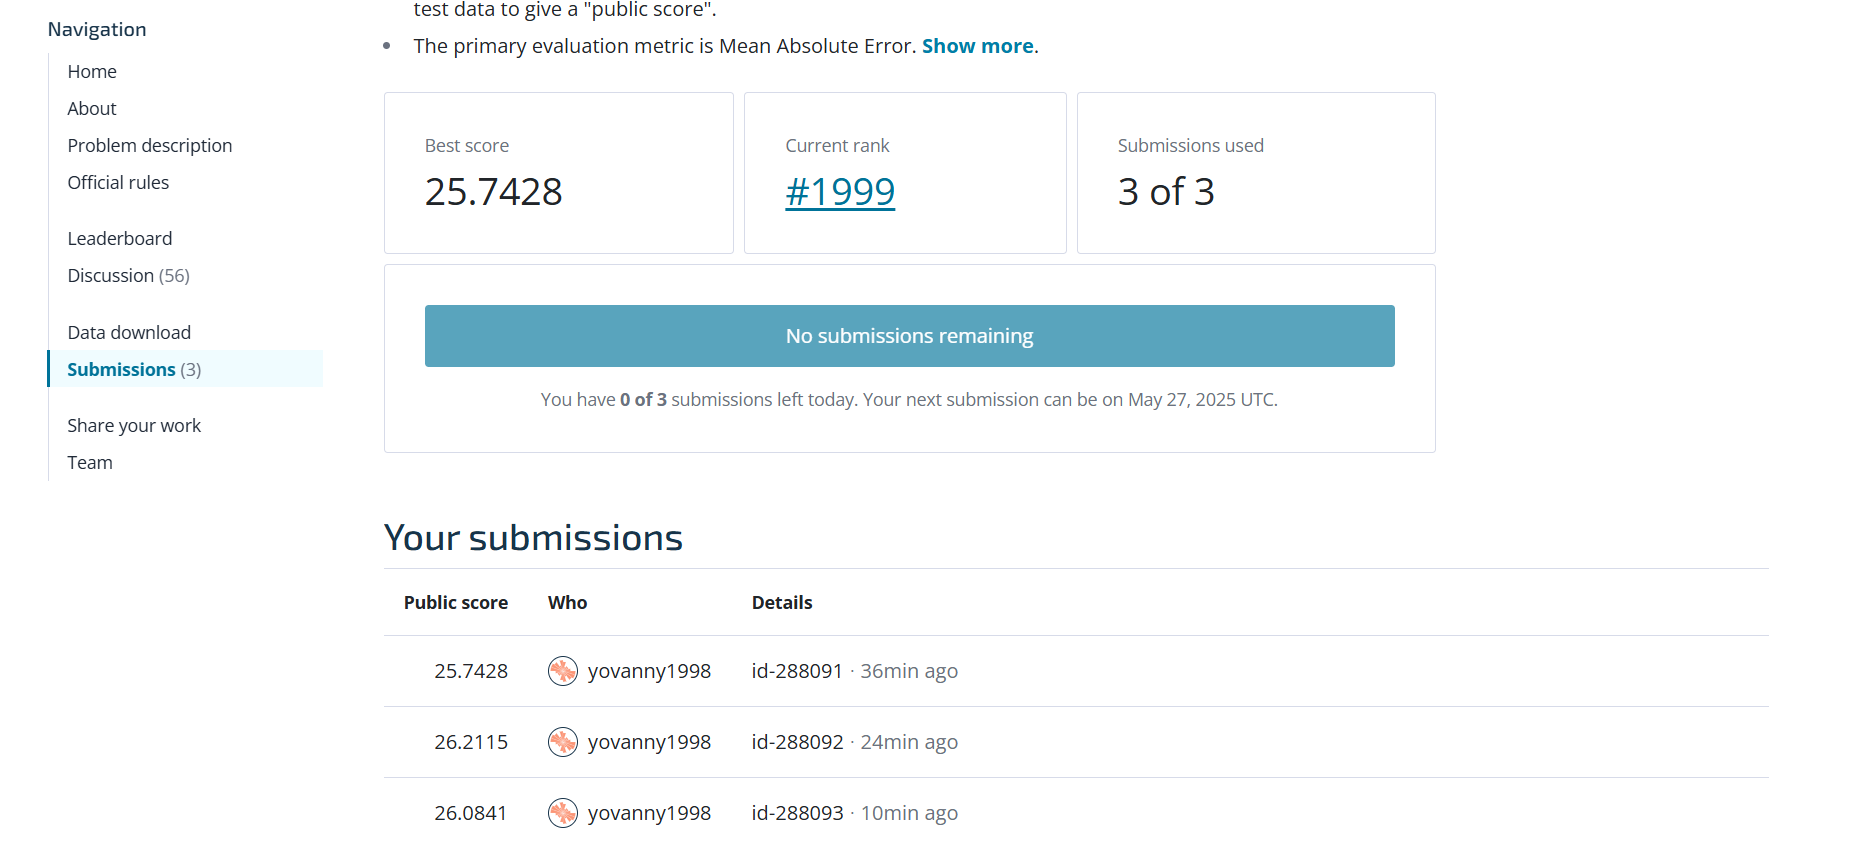

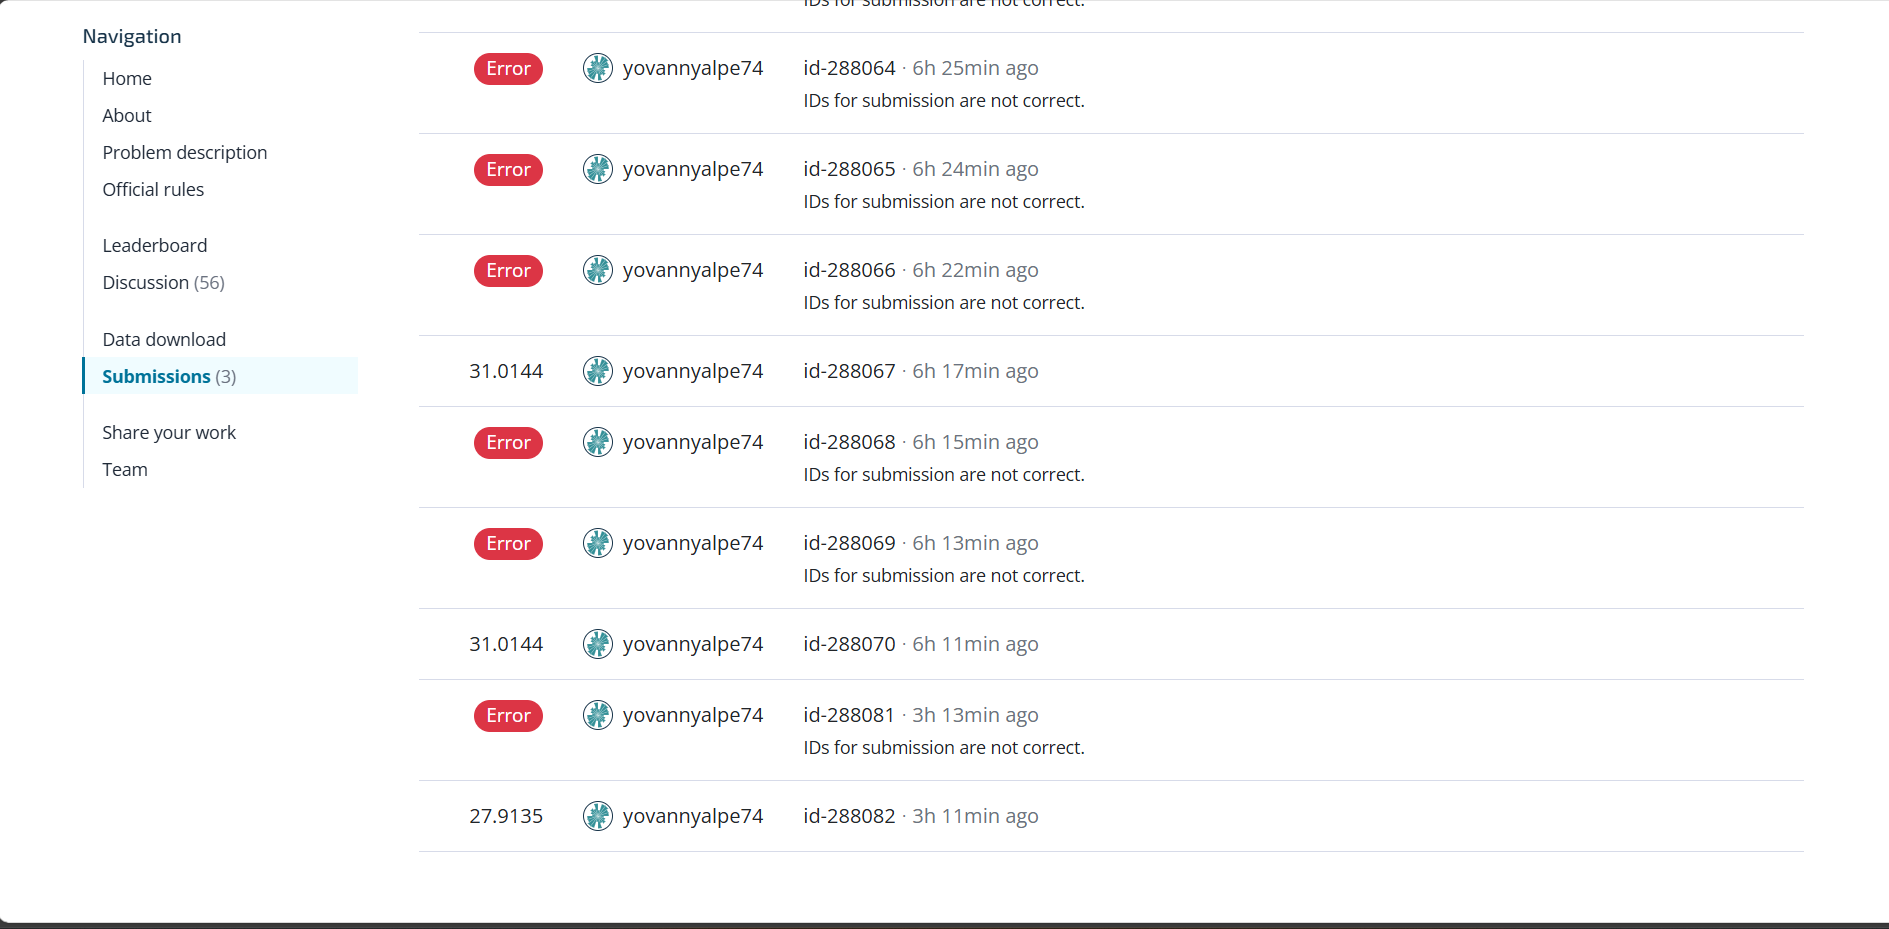

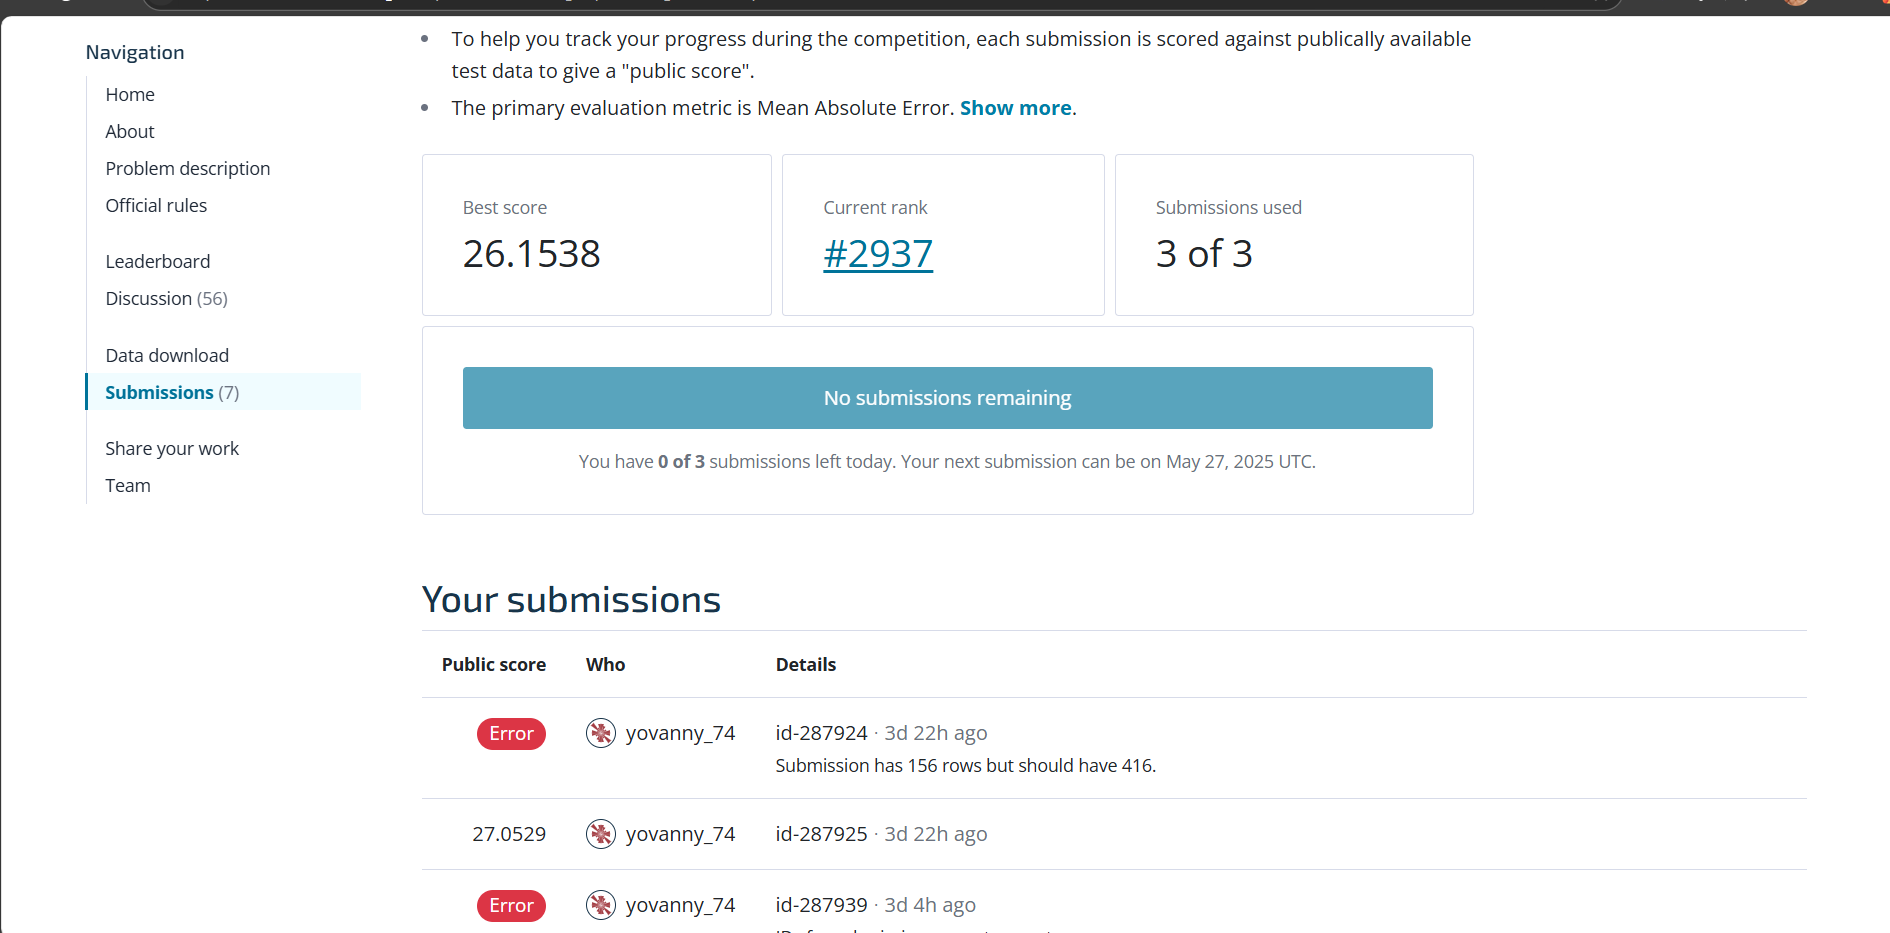

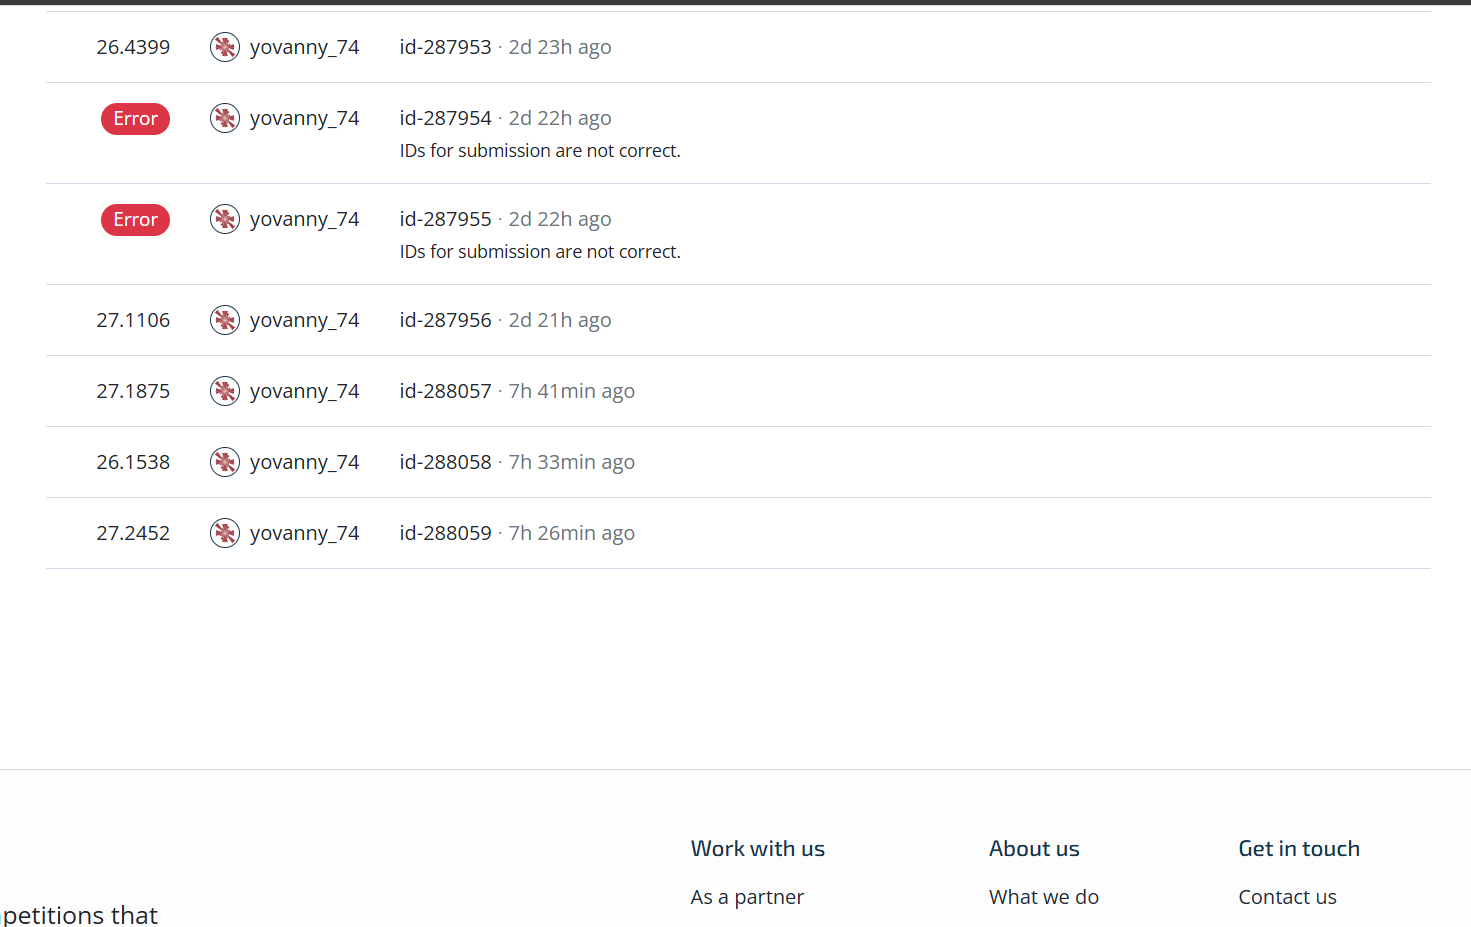

Utilicé tres usuarios distintos debido a que la plataforma solo permite un máximo de tres interacciones diarias por cuenta. En cada una de las capturas de pantalla se refleja el nombre del usuario correspondiente. Realicé varias pruebas hasta obtener la mejor puntuación MAE posible.

#### Apoyo recibido
Durante el desarrollo de esta práctica, conté con el apoyo de ChatGPT para aclarar algunas dudas sobre el código, comprobar errores y organizar las secciones según los requisitos de la plantilla. Todas las decisiones sobre modelos, preprocesado y evaluación fueron tomadas por mí, ajustadas a los criterios explicados en clase.

